In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import kornia
import torch



    
        
input = torch.tensor([
    [[
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
    ]],
    [[
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
    ]],
]) 
print (input.shape)
coord, resp = kornia.ConvSoftArgmax2d((3,3), (2,2), padding=(0,0),
                                      normalized_coordinates=False,
                                      temperature=torch.tensor(10.),
                                      output_value=True)(input)



torch.Size([2, 1, 5, 5])


In [54]:
inp2 = input.view(2,1,1,5,5)
import torch
import torch.nn as nn
import torch.nn.functional as F

from kornia.geometry import dsnt
from kornia.utils import create_meshgrid
from kornia.geometry import normalize_pixel_coordinates
from typing import Tuple, Union
def _get_center_kernel3d(d:int, h: int, w: int) -> torch.Tensor:
    '''Helper function, which generates a kernel to
    return center coordinates, when applied with F.conv2d to 3d coordinates grid
    Args:
         d (int): kernel depth
         h (int): kernel height
         w (int): kernel width
    Returns:
        conv_kernel (torch.Tensor) [3x3xdxhxw]
    '''
    center_kernel = torch.zeros(3, 3, d, h, w)
    center_kernel[0, 0, d // 2, h // 2, w // 2] = 1.0
    center_kernel[1, 1, d // 2, h // 2, w // 2] = 1.0
    center_kernel[2, 2, d // 2, h // 2, w // 2] = 1.0
    return center_kernel

def _get_window_grid_kernel3d(d:int, h: int, w: int) -> torch.Tensor:
    '''Helper function, which generates a kernel to return coordinates,
    residual to window center
    Args:
         d (int): kernel depth
         h (int): kernel height
         w (int): kernel width
    Returns:
        conv_kernel (torch.Tensor) [3x1xdxhxw]
    '''
    grid2d = create_meshgrid(h, w, True)
    z = torch.linspace(-1, 1, d).view(d,1,1,1)
    grid3d = torch.cat([z.repeat(1, h, w, 1).contiguous(), grid2d.repeat(d, 1, 1, 1)], dim=3)
    conv_kernel = grid3d.permute(3, 0, 1, 2).unsqueeze(1)
    return conv_kernel

In [32]:
wg = _get_center_kernel3d(4,5,6)
print (wg[2,0])
print (wg.shape)

tensor([[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]])
torch.Size([3, 1, 4, 5, 6])


In [48]:
from typing import Optional
def create_meshgrid3d(
        depth: int,
        height: int,
        width: int,
        normalized_coordinates: Optional[bool] = True) -> torch.Tensor:
    """Generates a coordinate grid for an image.

    When the flag `normalized_coordinates` is set to True, the grid is
    normalized to be in the range [-1,1] to be consistent with the pytorch
    function grid_sample.
    http://pytorch.org/docs/master/nn.html#torch.nn.functional.grid_sample

    Args:
        depth (int): the image depth (channels).
        height (int): the image height (rows).
        width (int): the image width (cols).
        normalized_coordinates (Optional[bool]): wether to normalize
          coordinates in the range [-1, 1] in order to be consistent with the
          PyTorch function grid_sample.

    Return:
        torch.Tensor: returns a grid tensor with shape :math:`(1, D, H, W, 3)`.
    """
    grid2d = create_meshgrid(height, width, normalized_coordinates)
    if normalized_coordinates:
        z = torch.linspace(-1, 1, depth)
    else:
        z = torch.linspace(0, depth - 1, depth)
    z = z.view (depth, 1, 1, 1)
    grid3d = torch.cat([z.repeat(1, height, width, 1).contiguous(), grid2d.repeat(depth, 1, 1, 1)], dim=3)
    return grid3d.unsqueeze(0) # 1xDxHxWx3
mg3 = create_meshgrid3d(5,13,25)
print (mg3.shape)

torch.Size([1, 5, 13, 25, 3])


In [60]:
def normalize_pixel_coordinates3d(
        pixel_coordinates: torch.Tensor,
        depth: int,
        height: int,
        width: int) -> torch.Tensor:
    r"""Normalize pixel coordinates between -1 and 1.

    Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1).

    Args:
        pixel_coordinate (torch.Tensor): the grid with pixel coordinates.
          Shape can be :math:`(*, 3)`.
        depth (int): the maximum depth in the z-axis.
        height (int): the maximum height in the y-axis.
        width (int): the maximum width in the x-axis.

    Return:
        torch.Tensor: the normalized pixel coordinates.
    """
    if pixel_coordinates.shape[-1] != 3:
        raise ValueError("Input pixel_coordinates must be of shape (*, 3). "
                         "Got {}".format(pixel_coordinates.shape))
    # compute normalization factor
    dhw: torch.Tensor = torch.stack([
        torch.tensor(depth), torch.tensor(width), torch.tensor(height)
    ]).to(pixel_coordinates.device).to(pixel_coordinates.dtype)

    factor: torch.Tensor = torch.tensor(2.) / (dhw - 1)

    return factor * pixel_coordinates - 1


def denormalize_pixel_coordinates3d(
        pixel_coordinates: torch.Tensor,
        depth: int,
        height: int,
        width: int) -> torch.Tensor:
    r"""Denormalize pixel coordinates.

    The input is assumed to be -1 if on extreme left, 1 if on
    extreme right (x = w-1).

    Args:
        pixel_coordinate (torch.Tensor): the normalized grid coordinates.
          Shape can be :math:`(*, 3)`.
        depth (int): the maximum depth in the x-axis.
        height (int): the maximum height in the y-axis.
        width (int): the maximum width in the x-axis.

    Return:
        torch.Tensor: the denormalized pixel coordinates.
    """
    if pixel_coordinates.shape[-1] != 3:
        raise ValueError("Input pixel_coordinates must be of shape (*, 3). "
                         "Got {}".format(pixel_coordinates.shape))
    # compute normalization factor
    dhw: torch.Tensor = torch.stack([
        torch.tensor(depth), torch.tensor(width), torch.tensor(height)
    ]).to(pixel_coordinates.device).to(pixel_coordinates.dtype)

    factor: torch.Tensor = torch.tensor(2.) / (dhw - 1)

    return torch.tensor(1.) / factor * (pixel_coordinates + 1)

In [59]:
center_kernel = _get_center_kernel3d(3, 5, 5)
grid_global = create_meshgrid3d(5, 13, 25, False).permute(0, 4, 1, 2, 3)
print (grid_global.shape, center_kernel.shape)
grid_global_pooled = F.conv3d(grid_global,
                              center_kernel,
                              stride=1,
                              padding=(1,2,2))
print (grid_global_pooled.shape)


torch.Size([1, 3, 5, 13, 25]) torch.Size([3, 3, 3, 5, 5])
torch.Size([1, 3, 5, 13, 25])


In [80]:
def conv_soft_argmax3d(input: torch.Tensor,
                       kernel_size: Tuple[int, int, int] = (3, 3, 3),
                       stride: Tuple[int, int, int] = (1, 1, 1),
                       padding: Tuple[int, int, int] = (1, 1, 1),
                       temperature: Union[torch.Tensor, float] = torch.tensor(1.0),
                       normalized_coordinates: bool = True,
                       eps: float = 1e-8,
                       output_value: bool = False) -> Union[torch.Tensor,
                                                            Tuple[torch.Tensor, torch.Tensor]]:
    """
    Function that computes the convolutional spatial Soft-Argmax 3D over the windows
    of a given input heatmap. Function has two outputs: argmax coordinates and the softmaxpooled heatmap values
    themselves.

    On each window, the function computed is:

    .. math::
        ijk(X) = \frac{\sum_{(i,j,k) * exp(x / T)  \in X}} {\sum_{exp(x / T)  \in X}}
        val(X) = \frac{\sum_{x * exp(x / T)  \in X}} {\sum_{exp(x / T)  \in X}}

    - where T is temperature.

    Args:
        kernel_size (Tuple([int,int,int])): the size of the window
        stride  (Tuple([int,int,int])): the stride of the window.
        padding (Tuple([int,int,int])): input zero padding
        temperature (torch.Tensor): factor to apply to input. Default is 1.
        normalized_coordinates (bool): whether to return the
          coordinates normalized in the range of [-1, 1]. Otherwise,
          it will return the coordinates in the range of the input shape.
          Default is True.
        eps (float): small value to avoid zero division. Default is 1e-8.
        output_value(bool): if True, val is outputed, if False, only ij


    Shape:
        - Input: :math:`(N, C, D_{in}, H_{in}, W_{in})`
        - Output: math:`(N, C, 3, D_{out}, H_{out}, W_{out})`, :math:`(N, C, D_{out}, H_{out}, W_{out})`, where

          .. math::
              H_{out} = \left\lfloor\frac{D_{in}  + 2 \times \text{padding}[0] -
              (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor

          .. math::
              H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[1] -
              (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor

          .. math::
              W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[2] -
              (\text{kernel\_size}[2] - 1) - 1}{\text{stride}[2]} + 1\right\rfloor

    Examples::

        >>> input = torch.randn(20, 16, 3, 50, 32)
        >>> nms_coords, nms_val = conv_soft_argmax2d(input, (3, 3, 3), (1, 2, 2), (0, 1, 1))
    """
    if not torch.is_tensor(input):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))
    if not len(input.shape) == 5:
        raise ValueError("Invalid input shape, we expect BxCxDxHxW. Got: {}"
                         .format(input.shape))
    if temperature <= 0:
        raise ValueError("Temperature should be positive float or tensor. Got: {}"
                         .format(temperature))

    b, c, d, h, w = input.shape
    input = input.view(b * c, 1, d, h, w)

    center_kernel = _get_center_kernel3d(kernel_size[0], kernel_size[1], kernel_size[2])
    window_kernel = _get_window_grid_kernel3d(kernel_size[0], kernel_size[1], kernel_size[2])
    window_kernel = window_kernel.to(input.device).to(input.dtype)

    x_exp = (input / temperature).exp()

    pool_coef: float = float(kernel_size[0] * kernel_size[1] * kernel_size[2])

    # softmax denominator
    den = pool_coef * F.avg_pool3d(x_exp.view(input.size()),
                                   kernel_size,
                                   stride=stride,
                                   padding=padding) + 1e-12

    x_softmaxpool = pool_coef * F.avg_pool3d(x_exp.view(input.size()) * input,
                                             kernel_size,
                                             stride=stride,
                                             padding=padding) / den
    x_softmaxpool = x_softmaxpool.view(b,
                                       c,
                                       x_softmaxpool.size(2),
                                       x_softmaxpool.size(3),
                                       x_softmaxpool.size(4))

    # We need to output also coordinates
    # Pooled window center coordinates
    grid_global: torch.Tensor = create_meshgrid3d(d, h, w, False).permute(0, 4, 1, 2, 3)
    grid_global = grid_global.to(input.device).to(input.dtype)
    grid_global_pooled = F.conv3d(grid_global,
                                  center_kernel.to(input.device).to(input.dtype),
                                  stride=stride,
                                  padding=padding)

    # Coordinates of maxima residual to window center
    # prepare kernel
    coords_max: torch.Tensor = F.conv3d(x_exp,
                                        window_kernel,
                                        stride=stride,
                                        padding=padding)

    coords_max = coords_max / den.expand_as(coords_max)
    coords_max = coords_max + grid_global_pooled.expand_as(coords_max)
    # [:,:, 0, ...] is x
    # [:,:, 1, ...] is y

    if normalized_coordinates:
        coords_max = normalize_pixel_coordinates3d(coords_max.permute(0, 2, 3, 4, 1), d, h, w)
        coords_max = coords_max.permute(0, 4, 1, 2, 3)

    # Back B*C -> (b, c)
    coords_max = coords_max.view(b, c, 3, coords_max.size(2), coords_max.size(3), coords_max.size(4))

    if output_value:
        return coords_max, x_softmaxpool
    return coords_max


In [94]:
print (inp2.shape)
coord, resp = conv_soft_argmax3d(inp2, (1, 3,3), (1, 1,1), padding=(0,1,1),
                                      normalized_coordinates=False,
                                      temperature=torch.tensor(10.),
                                      output_value=True)
print(resp.shape, coord.shape)

torch.Size([2, 1, 1, 5, 5])
torch.Size([2, 1, 1, 5, 5]) torch.Size([2, 1, 3, 1, 5, 5])


tensor([[[[[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000]]],


          [[[ 0.5128,  1.0000,  1.9828,  3.0000,  3.5000],
            [ 0.5086,  1.0000,  1.9884,  3.0000,  3.5000],
            [ 0.5086,  1.0000,  2.0000,  3.0000,  3.4914],
            [ 0.5000,  1.0000,  2.0116,  3.0000,  3.4914],
            [ 0.5000,  1.0000,  2.0172,  3.0000,  3.4872]]],


          [[[ 0.5128,  0.5086,  0.5086,  0.5000,  0.5000],
            [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
            [ 1.9828,  1.9884,  2.0000,  2.0116,  2.0172],
            [ 3.0000,  3.0000,  3.0000,  3.0000,  3.0000],
            [ 3.5000,  3.5000,  3.4914,  3.4914,  3.4872]]]]],




        [[[[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000, 

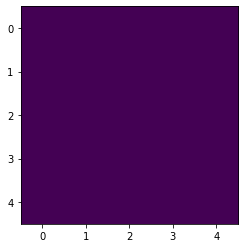

In [92]:
plt.imshow(kornia.utils.tensor_to_image(coord[0,0,0]))
print (coord)

In [ ]:
ef conv_soft_argmax3d(input: torch.Tensor,
                       kernel_size: Tuple[int, int, int] = (3, 3, 3),
                       stride: Tuple[int, int, int] = (1, 1, 1),
                       padding: Tuple[int, int, int] = (1, 1, 1),
                       temperature: Union[torch.Tensor, float] = torch.tensor(1.0),
                       normalized_coordinates: bool = True,
                       eps: float = 1e-8,
                       output_value: bool = False) -> Union[torch.Tensor,
                                                            Tuple[torch.Tensor, torch.Tensor]]:
    """
    Function that computes the convolutional spatial Soft-Argmax 3D over the windows
    of a given input heatmap. Function has two outputs: argmax coordinates and the softmaxpooled heatmap values
    themselves.

    On each window, the function computed is:

    .. math::
        ijk(X) = \frac{\sum_{(i,j,k) * exp(x / T)  \in X}} {\sum_{exp(x / T)  \in X}}
        val(X) = \frac{\sum_{x * exp(x / T)  \in X}} {\sum_{exp(x / T)  \in X}}

    - where T is temperature.

    Args:
        kernel_size (Tuple([int,int,int])): the size of the window
        stride  (Tuple([int,int,int])): the stride of the window.
        padding (Tuple([int,int,int])): input zero padding
        temperature (torch.Tensor): factor to apply to input. Default is 1.
        normalized_coordinates (bool): whether to return the
          coordinates normalized in the range of [-1, 1]. Otherwise,
          it will return the coordinates in the range of the input shape.
          Default is True.
        eps (float): small value to avoid zero division. Default is 1e-8.
        output_value(bool): if True, val is outputed, if False, only ij


    Shape:
        - Input: :math:`(N, C, D_{in}, H_{in}, W_{in})`
        - Output: math:`(N, C, 3, D_{out}, H_{out}, W_{out})`, :math:`(N, C, D_{out}, H_{out}, W_{out})`, where

          .. math::
              H_{out} = \left\lfloor\frac{D_{in}  + 2 \times \text{padding}[0] -
              (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor

          .. math::
              H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[1] -
              (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor

          .. math::
              W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[2] -
              (\text{kernel\_size}[2] - 1) - 1}{\text{stride}[2]} + 1\right\rfloor

    Examples::

        >>> input = torch.randn(20, 16, 3, 50, 32)
        >>> nms_coords, nms_val = conv_soft_argmax2d(input, (3, 3, 3), (1, 2, 2), (0, 1, 1))
    """
    if not torch.is_tensor(input):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))
    if not len(input.shape) == 5:
        raise ValueError("Invalid input shape, we expect BxCxDxHxW. Got: {}"
                         .format(input.shape))
    if temperature <= 0:
        raise ValueError("Temperature should be positive float or tensor. Got: {}"
                         .format(temperature))

    b, c, d, h, w = input.shape
    input = input.view(b * c, d, h, w)

    center_kernel = _get_center_kernel3d(kernel_size[0], kernel_size[1], kernel_size[2])
    window_kernel = _get_window_grid_kernel3d(kernel_size[0], kernel_size[1], kernel_size[2])
    window_kernel = window_kernel.to(input.device).to(input.dtype)

    x_exp = (input / temperature).exp()

    pool_coef: float = float(kernel_size[0] * kernel_size[1], kernel_size[2])

    # softmax denominator
    den = pool_coef * F.avg_pool3d(x_exp.view(input.size()),
                                   kernel_size,
                                   stride=stride,
                                   padding=padding) + 1e-12

    x_softmaxpool = pool_coef * F.avg_pool3d(x_exp.view(input.size()) * input,
                                             kernel_size,
                                             stride=stride,
                                             padding=padding) / den
    x_softmaxpool = x_softmaxpool.view(b,
                                       c,
                                       x_softmaxpool.size(2),
                                       x_softmaxpool.size(3),
                                       x_softmaxpool.size(4))

    # We need to output also coordinates
    # Pooled window center coordinates
    grid_global: torch.Tensor = create_meshgrid(h, w, False).permute(0, 3, 1, 2)
    grid_global = grid_global.to(input.device).to(input.dtype)
    grid_global_pooled = F.conv2d(grid_global,
                                  center_kernel.to(input.device).to(input.dtype),
                                  stride=stride,
                                  padding=padding)

    # Coordinates of maxima residual to window center
    # prepare kernel
    coords_max: torch.Tensor = F.conv2d(x_exp,
                                        window_kernel,
                                        stride=stride,
                                        padding=padding)

    coords_max = coords_max / den.expand_as(coords_max)
    coords_max = coords_max + grid_global_pooled.expand_as(coords_max)
    # [:,:, 0, ...] is x
    # [:,:, 1, ...] is y

    if normalized_coordinates:
        coords_max = normalize_pixel_coordinates(coords_max.permute(0, 2, 3, 1), h, w)
        coords_max = coords_max.permute(0, 3, 1, 2)

    # Back B*C -> (b, c)
    coords_max = coords_max.view(b, c, 2, coords_max.size(2), coords_max.size(3))

    if output_value:
        return coords_max, x_softmaxpool
    return coords_max


tensor([[[[[1., 3.],
           [1., 3.]],

          [[1., 1.],
           [3., 3.]]]]])


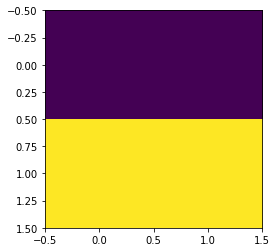

In [116]:
plt.imshow(kornia.utils.tensor_to_image(coord[:,:,1]))

print(coord)

torch.Size([1, 1, 3, 4])
tensor([[[[0.0000, 0.9996, 0.9996, 0.0000],
          [0.9996, 0.9998, 0.9998, 0.9996],
          [0.9996, 0.9998, 0.9998, 0.9996]]]])


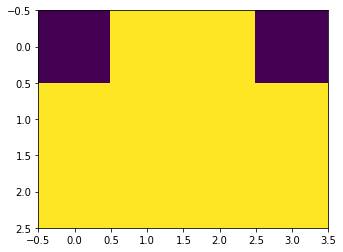